In [17]:
import numpy as np
import pandas as pd
import scanpy as sc

import decoupler as dc

import matplotlib.pyplot as plt

def plot_distribution(dataset_name, metric_name, results):
    msk = (results['dataset'] == dataset_name) & (results['metric'] == metric_name)
    random = results[msk]['random']
    gt = results[msk]['gt'].values[0]
    pval = results[msk]['p-value'].values[0]
    zscore = results[msk]['z-score'].values[0]
    
    # Creating the histogram
    plt.hist(random, bins=30, alpha=0.7, color='blue', label='Random Distribution')
    # Adding a vertical line for the ground truth performance
    plt.axvline(gt, color='red', linestyle='dashed', linewidth=2, label='Ground Truth Performance')

    # Adding labels and title
    plt.xlabel(metric_name)
    plt.ylabel('Frequency')
    plt.title(dataset_name)
    plt.legend()

    # Show the plot
    plt.show()

In [18]:
from utils import *

In [19]:
gt = get_ground_truth()

In [20]:
datasets = {}

datasets['Kuppe et al., 2022'] = process_kuppe()
datasets['Reichart et al., 2022'] = process_reichart()
datasets['Simonson et al., 2023'] = process_simonson()

/home/dbdimitrov/miniconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


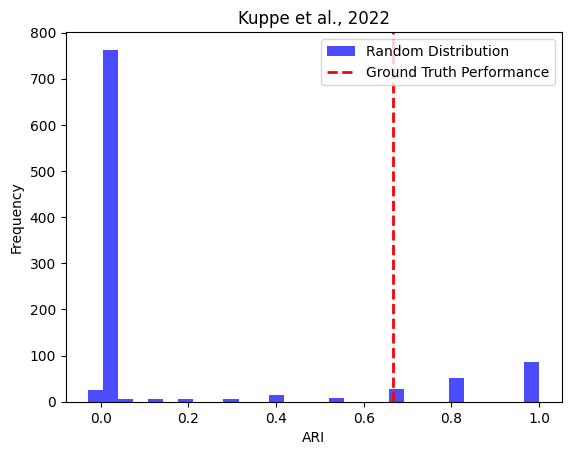

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


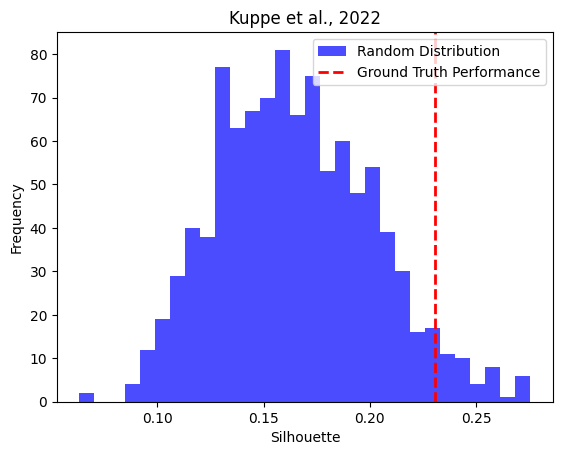

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


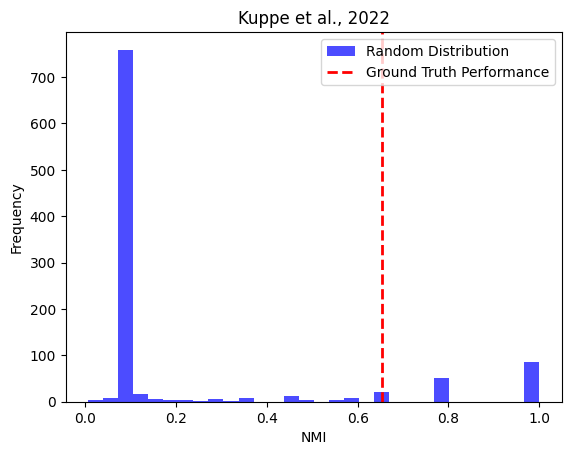

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


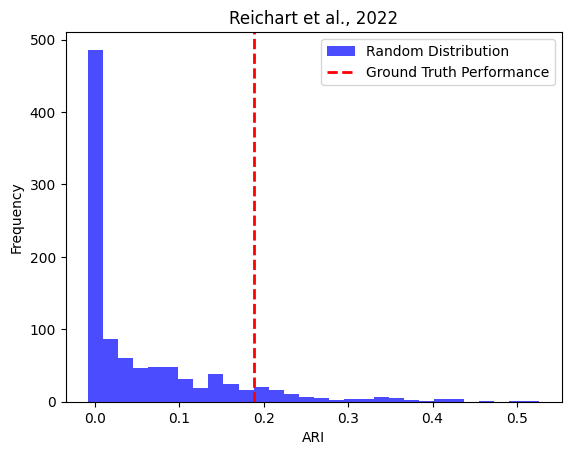

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


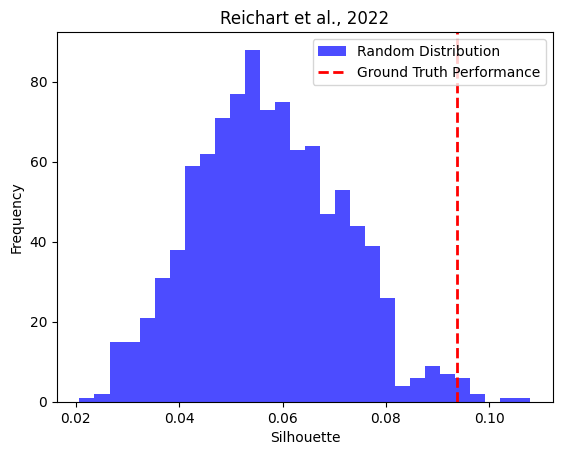

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


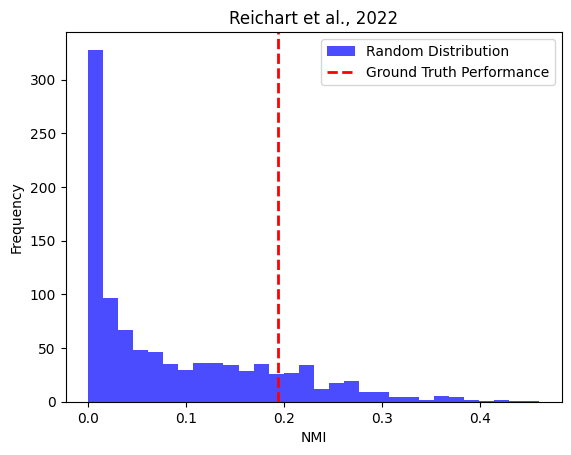

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


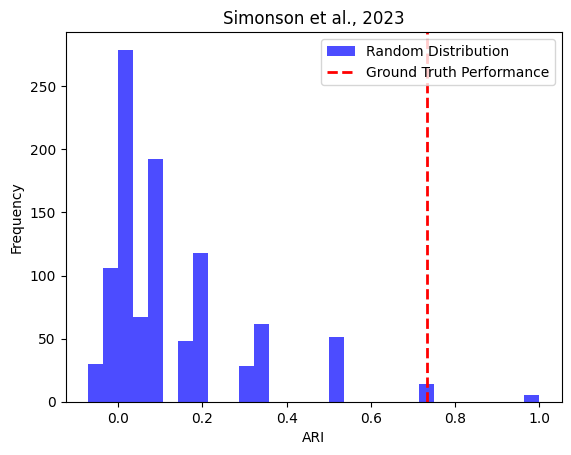

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


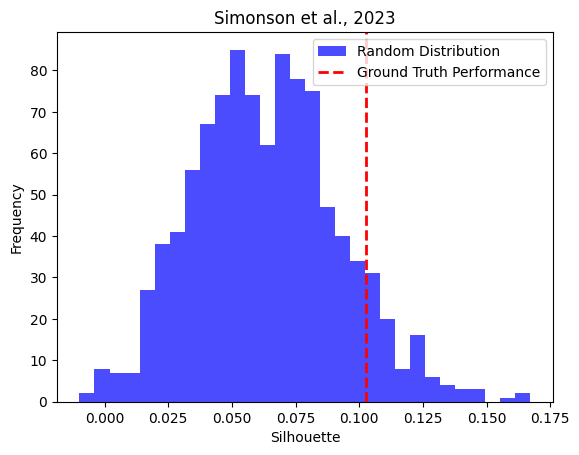

/tmp/ipykernel_3104030/1018870243.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


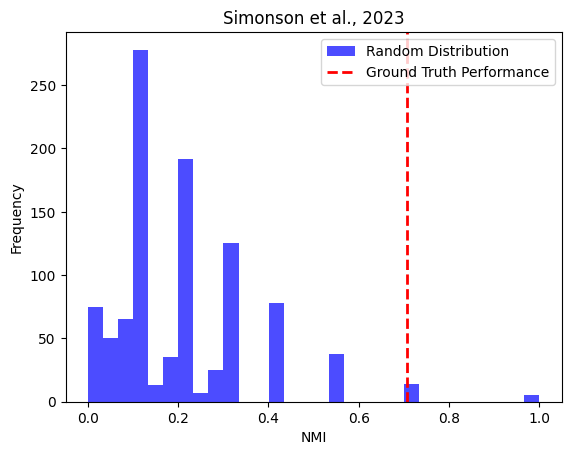

In [11]:
results = pd.DataFrame(columns=['dataset', 'metric', 'gt', 'p-value', 'z-score']).set_index('dataset')
for dataset_name, (pdata, y_true) in datasets.items():
    kmeans = KMeans(n_clusters=2, random_state=0).fit(pdata[:, gt].X)
    gt_ari = adjusted_rand_score(y_true, kmeans.labels_)
    gt_sil = silhouette_score(pdata[:, gt].X, y_true)
    gt_nmi = normalized_mutual_info_score(y_true, kmeans.labels_)


    rng = np.random.default_rng(0)
    subsets = [rng.choice(pdata.var.index, size=len(gt), replace=False) for _ in range(1000)]

    ari = []
    sil = []
    nmi = []
    # Printing subsets to verify
    for i, subset in enumerate(subsets):
        cdata = pdata[:,subset]
        kmeans = KMeans(n_clusters=2, random_state=0).fit(cdata.X)
        ari.append(adjusted_rand_score(y_true, kmeans.labels_))
        nmi.append(normalized_mutual_info_score(y_true, kmeans.labels_))
        sil.append(silhouette_score(cdata.X, y_true))
        
    # Calculate p-values and z-scores and populate the DataFrame
    metrics = {'ARI': (gt_ari, ari), 'Silhouette': (gt_sil, sil), 'NMI': (gt_nmi, nmi)}
    for metric_name, (gt_metric, metric_scores) in metrics.items():
        pvalue, zscore = calculate_p_value(gt_metric, metric_scores)
        results = results.append({'dataset': dataset_name, 
                                  'metric': metric_name, 
                                  'gt': gt_metric,
                                  'random': metric_scores,
                                  'p-value': pvalue,
                                  'z-score': zscore},
                                 ignore_index=True)
        
        plot_distribution(metric_name=metric_name, dataset_name=dataset_name, results=results)


In [16]:
results.groupby('metric').mean()

/tmp/ipykernel_3104030/1291209334.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,gt,p-value,z-score
metric,,,
ARI,0.529486,0.047202,2.218930
NMI,0.517533,0.070012,1.944116
Silhouette,0.142401,0.041690,1.916137
